# Project 3 Exploritory Graphs

## Load in Python Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

## Load in Data

In [3]:
demographics = pd.read_csv('data/Demographics.csv')
demographics.head()

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7


In [4]:
# Create dictonary of dexcom tables with each key being "id_{id_num}" and value being dexcom df
dexcoms = {}
for i in range(1, 17):
    if i == 3:
        continue
    id = str(i).zfill(3)
    dexcoms[f"id_{id}"] = (pd.read_csv(f'data/dexcom/Dexcom_{id}.csv')[12:]
                           .drop(columns='Index')
                           .reset_index(drop=True))
    dexcoms[f"id_{id}"]['Timestamp (YYYY-MM-DDThh:mm:ss)'] = pd.to_datetime(dexcoms[f"id_{id}"]['Timestamp (YYYY-MM-DDThh:mm:ss)'])
    dexcoms[f"id_{id}"] = dexcoms[f"id_{id}"].assign(date=dexcoms[f"id_{id}"]['Timestamp (YYYY-MM-DDThh:mm:ss)'].dt.date)

# View example df for id_001
dexcoms['id_001'].head()

,Timestamp (YYYY-MM-DDThh:mm:ss),Event Type,Event Subtype,Patient Info,Device Info,Source Device ID,Glucose Value (mg/dL),Insulin Value (u),Carb Value (grams),Duration (hh:mm:ss),Glucose Rate of Change (mg/dL/min),Transmitter Time (Long Integer),date
0,2020-02-13 17:23:32,EGV,NaN,NaN,NaN,iPhone G6,61.0,NaN,NaN,NaN,NaN,11101.0,2020-02-13
1,2020-02-13 17:28:32,EGV,NaN,NaN,NaN,iPhone G6,59.0,NaN,NaN,NaN,NaN,11401.0,2020-02-13
2,2020-02-13 17:33:32,EGV,NaN,NaN,NaN,iPhone G6,58.0,NaN,NaN,NaN,NaN,11701.0,2020-02-13
3,2020-02-13 17:38:32,EGV,NaN,NaN,NaN,iPhone G6,59.0,NaN,NaN,NaN,NaN,12001.0,2020-02-13
4,2020-02-13 17:43:31,EGV,NaN,NaN,NaN,iPhone G6,63.0,NaN,NaN,NaN,NaN,12301.0,2020-02-13


In [5]:
# Create dictonary of food_log tables with each key being "id_{id_num}" and value being dexcom df
food_logs = {}
for i in range(1, 17):
    if i == 3:
        continue
    id = str(i).zfill(3)
    food_logs[f"id_{id}"] = (pd.read_csv(f'data/food_log/Food_Log_{id}.csv'))
    food_logs[f"id_{id}"].columns = ["date", "time_of_day", "time_begin", "time_end",
                                     "logged_food", "amount", "unit", "searched_food",
                                     "calorie", "total_carb", "dietary_fiber", "sugar",
                                     "protein", "total_fat"]
    # time_of_day is inconsistently formated, use time_begin when possible
    food_logs[f"id_{id}"]['time_of_day'] = pd.to_datetime(food_logs[f"id_{id}"]['time_of_day'], errors='coerce', format='%H:%M:%S').dt.time
    food_logs[f"id_{id}"]['date'] = pd.to_datetime(food_logs[f"id_{id}"]['date'])
    food_logs[f"id_{id}"]['time_begin'] = pd.to_datetime(food_logs[f"id_{id}"]['time_begin'])

# View example df for id_001
food_logs['id_001'].head()

,date,time_of_day,time_begin,time_end,logged_food,amount,unit,searched_food,calorie,total_carb,dietary_fiber,sugar,protein,total_fat
0,2020-02-13,18:00:00,2020-02-13 18:00:00,NaN,Berry Smoothie,20.00,fluid ounce,Strawberry Smoothie,456.0,85.0,1.7,83.0,16.0,3.3
1,2020-02-13,20:30:00,2020-02-13 20:30:00,NaN,Chicken Leg,1.00,NaN,chicken leg,475.0,0.0,0.0,0.0,62.0,23.0
2,2020-02-13,20:30:00,2020-02-13 20:30:00,NaN,Asparagus,4.00,NaN,Asparagus,13.0,2.5,1.2,0.8,1.4,0.1
3,2020-02-14,07:10:00,2020-02-14 07:10:00,NaN,Natrel Lactose Free 2 Percent,8.00,fluid ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,120.0,9.0,NaN,8.0,12.0,NaN
4,2020-02-14,07:10:00,2020-02-14 07:10:00,NaN,Standard Breakfast,0.75,cup,"(Kellogg's) Frosted Flakes, Cereal",110.0,26.0,NaN,10.0,1.0,NaN


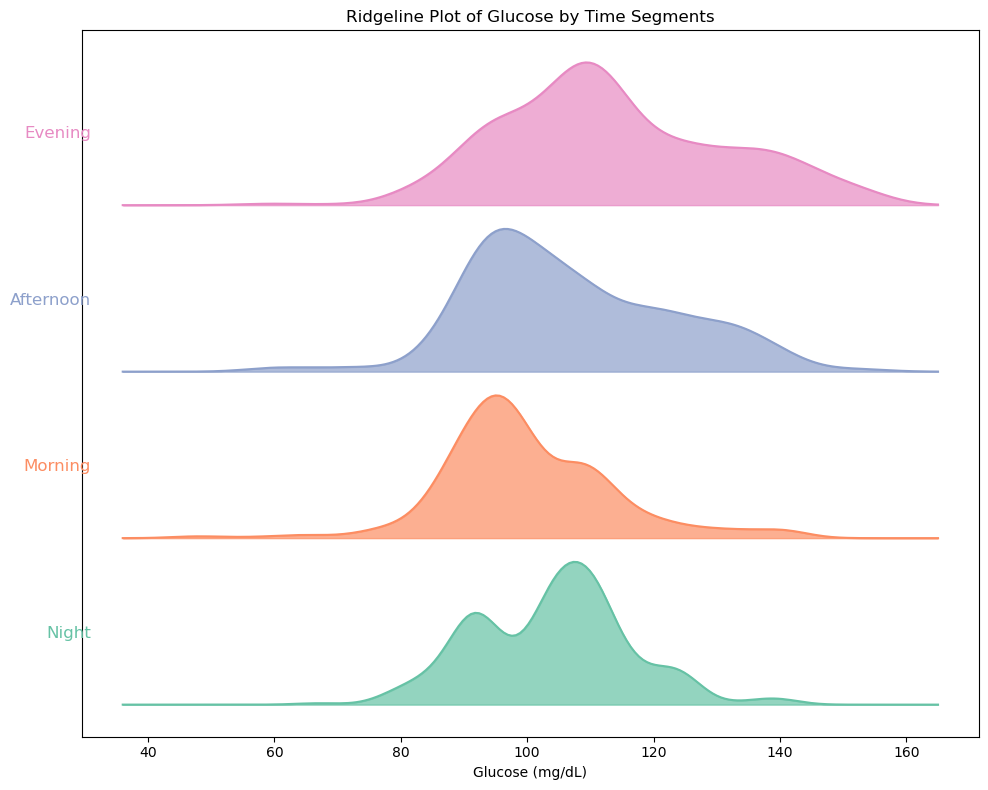

In [7]:
dexcom_df = dexcoms['id_001']

dexcom_df['Timestamp'] = pd.to_datetime(dexcom_df['Timestamp (YYYY-MM-DDThh:mm:ss)'])
dexcom_df['hour'] = dexcom_df['Timestamp'].dt.hour + dexcom_df['Timestamp'].dt.minute/60

def assign_segment(hour):
    if hour < 6:
        return "Night"
    elif hour < 12:
        return "Morning"
    elif hour < 18:
        return "Afternoon"
    else:
        return "Evening"

dexcom_df['segment'] = dexcom_df['hour'].apply(assign_segment)
segment_order = ["Night", "Morning", "Afternoon", "Evening"]
dexcom_df['segment'] = pd.Categorical(dexcom_df['segment'], categories=segment_order, ordered=True)

# --- Ridgeline Plot ---
# Set up the figure
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Use a seaborn color palette for distinct colors.
colors = sns.color_palette("Set2", len(segment_order))

# Set spacing variables for plotting
y_offset = 0  # this will be updated as we plot each segment
spacing = 0.5  # additional vertical spacing between groups

# Define the grid over which to evaluate densities.
# We'll choose a grid that spans the overall range of glucose values.
xmin = dexcom_df['Glucose Value (mg/dL)'].min() - 10
xmax = dexcom_df['Glucose Value (mg/dL)'].max() + 10
x_grid = np.linspace(xmin, xmax, 200)

# Loop over each segment in order.
for i, segment in enumerate(segment_order):
    # Extract glucose values for this segment.
    segment_data = dexcom_df[dexcom_df['segment'] == segment]['Glucose Value (mg/dL)'].dropna()
    if len(segment_data) == 0:
        continue  # skip if no data
    # Compute kernel density estimate.
    kde = gaussian_kde(segment_data)
    density = kde(x_grid)
    # Normalize the density (optional; can help in aligning plots)
    density = density / density.max()
    # Multiply to exaggerate vertical height
    density = density * 3

    # Plot the filled density curve with a vertical offset.
    ax.fill_between(x_grid, y_offset, density + y_offset, 
                    color=colors[i], alpha=0.7, label=segment)
    ax.plot(x_grid, density + y_offset, color=colors[i])

    # Place the segment label on the left of the curve.
    ax.text(xmin - 5, y_offset + (density.max()/2), segment, 
            ha='right', va='center', fontsize=12, color=colors[i])
    
    # Increase the offset for the next segment.
    y_offset += density.max() + spacing

# Remove y-axis ticks (they don't correspond to absolute density values)
ax.set_yticks([])
ax.set_xlabel("Glucose (mg/dL)")
ax.set_title("Ridgeline Plot of Glucose by Time Segments")

plt.tight_layout()
plt.show()